# Austin MetroBike Trips and Kiosk Stations

# [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb)

### Download and install Spark

In [1]:
!apt-get update 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null 
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz 
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [49.8 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hi

### Setup environment

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

### Import Austin's MetroBike Trips Data from Austin's Open Data Portal

In [3]:
!wget -O Austin-MetroBike-Trips.csv https://data.austintexas.gov/api/views/tyfh-5r8s/rows.csv?accessType=DOWNLOAD

--2021-03-31 18:05:04--  https://data.austintexas.gov/api/views/tyfh-5r8s/rows.csv?accessType=DOWNLOAD
Resolving data.austintexas.gov (data.austintexas.gov)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.austintexas.gov (data.austintexas.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Austin-MetroBike-Trips.csv’

Austin-MetroBike-Tr     [          <=>       ] 135.51M  4.76MB/s    in 29s     

2021-03-31 18:05:32 (4.74 MB/s) - ‘Austin-MetroBike-Trips.csv’ saved [142094609]



In [4]:
mt = spark.read.csv('Austin-MetroBike-Trips.csv',header=True)
mt.show(5)

+----------+--------------------+----------+-------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+
|   Trip ID|     Membership Type|Bicycle ID|Checkout Date|Checkout Time|Checkout Kiosk ID|      Checkout Kiosk|Return Kiosk ID|        Return Kiosk|Trip Duration Minutes|Month|Year|
+----------+--------------------+----------+-------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+
|9900285854|Annual (San Anton...|       207|   10/26/2014|     13:12:00|             2537|      West & 6th St.|           2707|Rainey St @ Cummings|                   76|   10|2014|
|9900285855|24-Hour Kiosk (Au...|       969|   10/26/2014|     13:12:00|             2498|Convention Center...|           2566|Pfluger Bridge @ ...|                   58|   10|2014|
|9900285856|Annual Membership...|       214|   10/26/2014|     13:12:00|             2537|

In [ ]:
mt.describe().show()

+-------+--------------------+--------------------+------------------+-------------+-------------+------------------+--------------------+------------------+--------------------+---------------------+------------------+------------------+
|summary|             Trip ID|     Membership Type|        Bicycle ID|Checkout Date|Checkout Time| Checkout Kiosk ID|      Checkout Kiosk|   Return Kiosk ID|        Return Kiosk|Trip Duration Minutes|             Month|              Year|
+-------+--------------------+--------------------+------------------+-------------+-------------+------------------+--------------------+------------------+--------------------+---------------------+------------------+------------------+
|  count|             1264113|             1257588|           1263390|      1264113|      1264113|           1245082|             1264113|           1244329|             1264113|              1264113|            618479|            618479|
|   mean|2.7744715697301702E9|              

In [ ]:
mt.explain()

== Physical Plan ==
FileScan csv [Trip ID#16,Membership Type#17,Bicycle ID#18,Checkout Date#19,Checkout Time#20,Checkout Kiosk ID#21,Checkout Kiosk#22,Return Kiosk ID#23,Return Kiosk#24,Trip Duration Minutes#25,Month#26,Year#27] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/content/Austin-MetroBike-Trips.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Trip ID:string,Membership Type:string,Bicycle ID:string,Checkout Date:string,Checkout Time...




In [ ]:
mt.schema

StructType(List(StructField(Trip ID,StringType,true),StructField(Membership Type,StringType,true),StructField(Bicycle ID,StringType,true),StructField(Checkout Date,StringType,true),StructField(Checkout Time,StringType,true),StructField(Checkout Kiosk ID,StringType,true),StructField(Checkout Kiosk,StringType,true),StructField(Return Kiosk ID,StringType,true),StructField(Return Kiosk,StringType,true),StructField(Trip Duration Minutes,StringType,true),StructField(Month,StringType,true),StructField(Year,StringType,true)))

### Transform datetime format

In [5]:
from pyspark.sql.functions import to_timestamp,date_format, col,lit
mt = spark.read.csv('Austin-MetroBike-Trips.csv',header=True).withColumn('Checkout Date',to_timestamp(col('Checkout Date'),'MM/dd/yyyy'))
mt = mt.withColumnRenamed('Checkout Date', 'Checkout_Date')
mt = mt.withColumnRenamed('Checkout Time', 'Checkout_Time')

In [6]:
from pyspark.sql.functions import year
from pyspark.sql.functions import quarter
from pyspark.sql.functions import month

from pyspark.sql.functions import dayofmonth
from pyspark.sql.functions import dayofyear
from pyspark.sql.functions import dayofweek

from pyspark.sql.functions import unix_timestamp, to_date

mt = mt.withColumn('Year',year(mt.Checkout_Date))
mt = mt.withColumn('Month',month(mt.Checkout_Date))
# mt = mt.withColumn('Quarter',quarter(mt.Checkout_Date))

mt = mt.withColumn('day_of_month',dayofmonth(mt.Checkout_Date))
# mt = mt.withColumn('day_of_year',dayofyear(mt.Checkout_Date))
mt = mt.withColumn('day_of_week',dayofweek(mt.Checkout_Date))
mt = mt.withColumn('Dow_Text', date_format(col('Checkout_Date'),'E'))

from pyspark.sql.functions import hour
from pyspark.sql.functions import minute
from pyspark.sql.functions import second

mt = mt.withColumn('hour',hour(mt.Checkout_Time))
# mt = mt.withColumn('minute',minute(mt.Checkout_Time))
# mt = mt.withColumn('second',second(mt.Checkout_Time))

mt.show(5)

# mt = mt.withColumn("Checkout_Date",to_timestamp(col("Checkout_Date"))).withColumn("D_O_M", date_format(col("Checkout_Date"), "d"))
# mt = mt.withColumn("Checkout_Date",to_timestamp(col("Checkout_Date"))).withColumn("D_O_Y", date_format(col("Checkout_Date"), "D")) 
# mt = mt.withColumn("Checkout_Date",to_timestamp(col("Checkout_Date"))).withColumn("D_O_W", date_format(col("Checkout_Date"), "D")) 

+----------+--------------------+----------+-------------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+------------+-----------+--------+----+
|   Trip ID|     Membership Type|Bicycle ID|      Checkout_Date|Checkout_Time|Checkout Kiosk ID|      Checkout Kiosk|Return Kiosk ID|        Return Kiosk|Trip Duration Minutes|Month|Year|day_of_month|day_of_week|Dow_Text|hour|
+----------+--------------------+----------+-------------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+------------+-----------+--------+----+
|9900285854|Annual (San Anton...|       207|2014-10-26 00:00:00|     13:12:00|             2537|      West & 6th St.|           2707|Rainey St @ Cummings|                   76|   10|2014|          26|          1|     Sun|  13|
|9900285855|24-Hour Kiosk (Au...|       969|2014-10-26 00:00:00|     13:12:00|             2

### Remove duplicate or missing data, check the new count

In [7]:
mt = mt.dropDuplicates()
mt = mt.na.drop()

In [ ]:
mt.count()

1264113

### Feature Exploration

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
mt.toPandas().to_csv('mtv.csv')

In [41]:
mtv = pd.read_csv("mtv.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


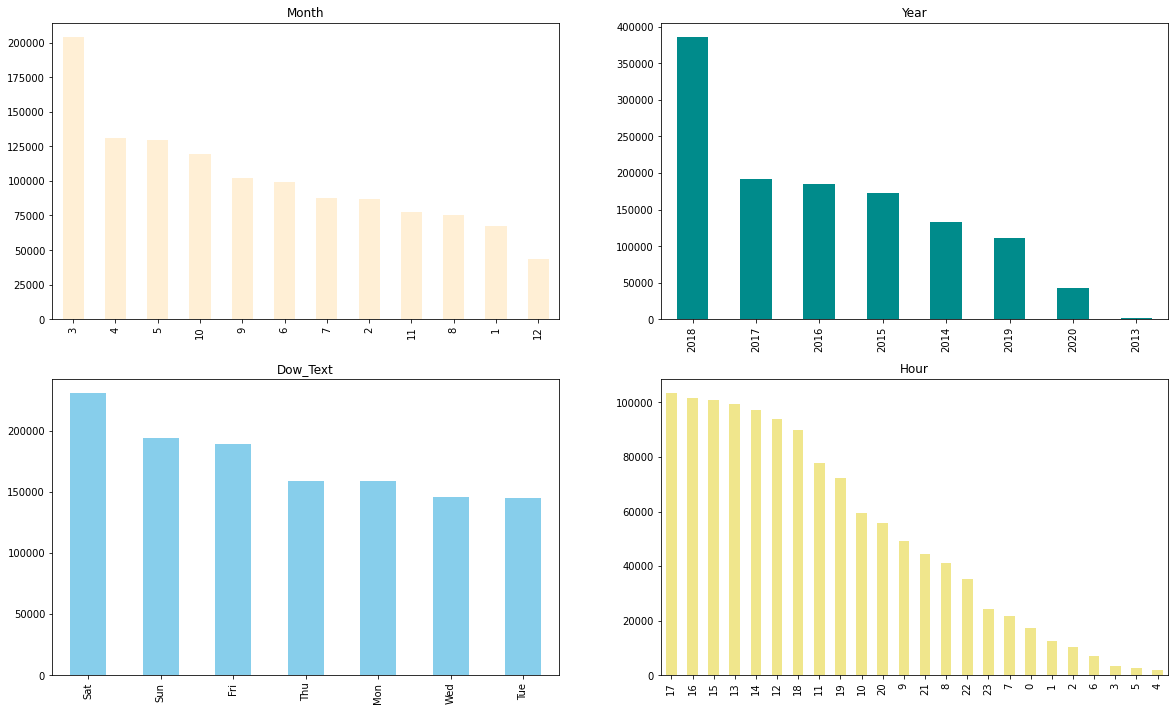

In [42]:
# Dataset pattern overview
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
mtv['Month'].value_counts().plot(kind='bar', color="papayawhip", ax=axes[0][0], title="Month")
mtv['Year'].value_counts().plot(kind='bar', color="darkcyan", ax=axes[0][1], title="Year")
# mtv['Quarter'].value_counts().plot(kind='bar', color="lightcoral", ax=axes[0][2], title="Quarter")
mtv['Dow_Text'].value_counts().plot(kind='bar', color="skyblue", ax=axes[1][0], title="Dow_Text")
# mtv['day_of_month'].value_counts().plot(kind='bar', color="plum", ax=axes[1][1], title="Day of Month")
mtv['hour'].value_counts().plot(kind='bar', color="khaki", ax=axes[1][1], title="Hour")
plt.show()

### Highlight of 2018 success

In [10]:
mt.groupby('Year').count().orderBy('Year',ascending=True).show()

+----+------+
|Year| count|
+----+------+
|2013|  1457|
|2014|133610|
|2015|172049|
|2016|184516|
|2017|191407|
|2018|386102|
|2019|111370|
|2020| 42340|
+----+------+



In [9]:
from pyspark.sql.types import IntegerType
mt = mt.withColumn("Trip Duration Minutes",mt["Trip Duration Minutes"].cast(IntegerType()))

In [ ]:
mt.groupBy('Year').sum('Trip Duration Minutes').orderBy('Year').show()

+----+--------------------------+
|Year|sum(Trip Duration Minutes)|
+----+--------------------------+
|2013|                     58477|
|2014|                   4622248|
|2015|                   4948154|
|2016|                   5405110|
|2017|                   6047570|
|2018|                   9310591|
|2019|                   5176890|
|2020|                   2375429|
+----+--------------------------+



Brainstorm
1.   Why is there a sharp decline in 2019 usage? Facility maintenance? Marketing? etc.
2.   Are any additional operating data available?
3.   Is there some similar decline in other cities without a public transportation system?


### Import Los Angeles Metro Bike Share Trip Data

In [11]:
!wget -O LA-MetroBike-Trips.csv https://data.lacity.org/api/views/sii9-rjps/rows.csv?accessType=DOWNLOAD

--2021-03-31 18:10:51--  https://data.lacity.org/api/views/sii9-rjps/rows.csv?accessType=DOWNLOAD
Resolving data.lacity.org (data.lacity.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.lacity.org (data.lacity.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘LA-MetroBike-Trips.csv’

LA-MetroBike-Trips.     [     <=>            ]  23.48M  3.63MB/s    in 6.4s    

2021-03-31 18:10:58 (3.67 MB/s) - ‘LA-MetroBike-Trips.csv’ saved [24618672]



In [12]:
la = spark.read.csv('LA-MetroBike-Trips.csv',header=True)
la.show(5)

+--------+--------+--------------------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+
| Trip ID|Duration|          Start Time|            End Time|Starting Station ID|Starting Station Latitude|Starting Station Longitude|Ending Station ID|Ending Station Latitude|Ending Station Longitude|Bike ID|Plan Duration|Trip Route Category|Passholder Type|Starting Lat-Long|Ending Lat-Long|
+--------+--------+--------------------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+
|17945760|    1560|01/15/2017 11:21:...|01/15/2017 11:47:...|               3052|                34.051102|           

In [ ]:
la.schema

StructType(List(StructField(Trip ID,StringType,true),StructField(Duration,StringType,true),StructField(Start Time,StringType,true),StructField(End Time,StringType,true),StructField(Starting Station ID,StringType,true),StructField(Starting Station Latitude,StringType,true),StructField(Starting Station Longitude,StringType,true),StructField(Ending Station ID,StringType,true),StructField(Ending Station Latitude,StringType,true),StructField(Ending Station Longitude,StringType,true),StructField(Bike ID,StringType,true),StructField(Plan Duration,StringType,true),StructField(Trip Route Category,StringType,true),StructField(Passholder Type,StringType,true),StructField(Starting Lat-Long,StringType,true),StructField(Ending Lat-Long,StringType,true)))

In [13]:
la.select("Start Time").show(truncate=False)
# As the Start Time colume contains texts, lpad and split will be applied to extract year info

+----------------------+
|Start Time            |
+----------------------+
|01/15/2017 11:21:00 AM|
|12/28/2016 01:02:00 PM|
|10/09/2016 09:40:00 AM|
|02/01/2017 07:43:00 AM|
|01/04/2017 12:48:00 PM|
|12/28/2016 03:27:00 PM|
|03/26/2017 01:57:00 AM|
|01/21/2017 03:38:00 PM|
|03/16/2017 12:42:00 PM|
|01/28/2017 04:12:00 PM|
|03/26/2017 01:15:00 PM|
|11/17/2016 03:32:00 PM|
|01/21/2017 11:25:00 AM|
|02/18/2017 12:05:00 AM|
|03/15/2017 04:55:00 PM|
|01/21/2017 11:28:00 PM|
|08/31/2016 10:38:00 PM|
|09/25/2016 03:28:00 PM|
|08/23/2016 07:49:00 AM|
|08/03/2016 11:01:00 PM|
+----------------------+
only showing top 20 rows



In [14]:
from pyspark.sql.functions import lpad

In [15]:
la = la.withColumn('Start Time',lpad(col('Start Time'),10,'0'))
la.show(5)

+--------+--------+----------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+
| Trip ID|Duration|Start Time|            End Time|Starting Station ID|Starting Station Latitude|Starting Station Longitude|Ending Station ID|Ending Station Latitude|Ending Station Longitude|Bike ID|Plan Duration|Trip Route Category|Passholder Type|Starting Lat-Long|Ending Lat-Long|
+--------+--------+----------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+
|17945760|    1560|01/15/2017|01/15/2017 11:47:...|               3052|                34.051102|               -118.264557|             3000|      

In [16]:
la = la.withColumnRenamed('Start Time', 'Start_Time')

In [17]:
from pyspark.sql.functions import split

In [18]:
la = la.withColumn("month", split(col("Start_Time"), "/").getItem(0)).withColumn("day", split(col("Start_Time"), "/").getItem(1)).withColumn("year", split(col("Start_Time"), "/").getItem(2))
la.show(5)

+--------+--------+----------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+-----+---+----+
| Trip ID|Duration|Start_Time|            End Time|Starting Station ID|Starting Station Latitude|Starting Station Longitude|Ending Station ID|Ending Station Latitude|Ending Station Longitude|Bike ID|Plan Duration|Trip Route Category|Passholder Type|Starting Lat-Long|Ending Lat-Long|month|day|year|
+--------+--------+----------+--------------------+-------------------+-------------------------+--------------------------+-----------------+-----------------------+------------------------+-------+-------------+-------------------+---------------+-----------------+---------------+-----+---+----+
|17945760|    1560|01/15/2017|01/15/2017 11:47:...|               3052|                34.051102|      

In [19]:
la.count()

132427

In [20]:
la.groupby('year').count().orderBy('year',ascending=False).show()

+----+-----+
|year|count|
+----+-----+
|2017|33786|
|2016|98641|
+----+-----+



In [21]:
la = la.dropDuplicates()
la = la.na.drop()

In [22]:
la.count()

97825

After checking other open data portals in San Francisco, Seattle, Portland, Philadelphia, Orlando, Houston, the search for usable city bike trips data didn't turn out to be as lucky.

### The popular Kiosk stations in Austin



In [23]:
mt.select("Checkout Kiosk ID").distinct().count()

97

In [ ]:
Checkout_count = mt.groupBy('Checkout Kiosk ID').count().orderBy('count',ascending=False).show(10)

+-----------------+-----+
|Checkout Kiosk ID|count|
+-----------------+-----+
|             3798|77529|
|             2575|42947|
|             2707|37429|
|             2499|36888|
|             2494|35943|
|             2501|34574|
|             2563|32472|
|             2495|31762|
|             2498|31099|
|             2566|29167|
|             2548|28910|
|             2497|27979|
|             2547|26836|
|             3794|26188|
|             3841|25978|
|             2552|25641|
|             3792|24497|
|             2574|24404|
|             2549|23397|
|             3793|23058|
+-----------------+-----+
only showing top 20 rows



In [ ]:
mt.filter(col('Checkout Kiosk ID') == '3798').count()/1264113

0.06146602400260103

In [ ]:
Return_count =  mt.groupBy('Return Kiosk ID').count().orderBy('count',ascending=False).show(10)

+---------------+-----+
|Return Kiosk ID|count|
+---------------+-----+
|           3798|80351|
|           2499|42711|
|           2575|42296|
|           2494|39534|
|           2707|36487|
|           2495|35828|
|           2498|33726|
|           2501|33099|
|           2563|32052|
|           2566|28622|
|           3794|28591|
|           2547|26762|
|           2574|26434|
|           2548|26227|
|           2549|24483|
|           2497|24324|
|           2552|23619|
|           3841|23515|
|           2711|22466|
|           2539|21856|
+---------------+-----+
only showing top 20 rows



In [ ]:
mt.select("Bicycle ID").distinct().count()

837

In [ ]:
mt.groupBy("Bicycle ID").sum("Trip Duration Minutes").orderBy('sum(Trip Duration Minutes)',ascending=False).show(truncate=False)

+----------+--------------------------+
|Bicycle ID|sum(Trip Duration Minutes)|
+----------+--------------------------+
|893       |112488                    |
|135       |109093                    |
|843       |103745                    |
|575       |102822                    |
|122       |101816                    |
|861       |101748                    |
|447       |101312                    |
|102       |101222                    |
|19        |100493                    |
|862       |99220                     |
|235       |98868                     |
|152       |98200                     |
|460       |97398                     |
|391       |97313                     |
|951       |97058                     |
|208       |96948                     |
|507       |96120                     |
|52        |95990                     |
|920       |95576                     |
|520       |95408                     |
+----------+--------------------------+
only showing top 20 rows



It would be a good practice to check if the bikes with a high value of total usage hours are due for maintenance or replacement

### Membership for locals

In [24]:
mt.groupby('Membership Type').count().orderBy('count',ascending=False).show(35, truncate=False)

+------------------------------------------------+------+
|Membership Type                                 |count |
+------------------------------------------------+------+
|Walk Up                                         |363547|
|U.T. Student Membership                         |284687|
|Local365                                        |203838|
|24-Hour Kiosk (Austin B-cycle)                  |91201 |
|Local30                                         |66010 |
|Weekender                                       |44871 |
|Annual Membership (Austin B-cycle)              |27895 |
|Explorer                                        |25598 |
|24 Hour Walk Up Pass                            |22658 |
|Local365+Guest Pass                             |13768 |
|Single Trip                                     |12068 |
|Single Trip (Pay-as-you-ride)                   |8664  |
|3-Day Explorer                                  |6219  |
|Pay-as-you-ride                                 |5530  |
|Single Trip  

In [25]:
mtlocal = mt.filter( (col('Membership Type') == 'Local365') | (col('Membership Type') == 'Local30') | (col('Membership Type') == 'Local365+Guest Pass') | (col('Membership Type') == 'Local365+Guest Pass') | (col('Membership Type') == 'Local365 ($80 plus tax)') | (col('Membership Type') == 'Local365- 1/2 off Anniversary Special')| (col('Membership Type') == 'Local30 ($11 plus tax)') | (col('Membership Type') == 'Local365 Youth (age 13-17 riders)'))
mtlocal.show(5)

+----------+---------------+----------+-------------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+------------+-----------+--------+----+
|   Trip ID|Membership Type|Bicycle ID|      Checkout_Date|Checkout_Time|Checkout Kiosk ID|      Checkout Kiosk|Return Kiosk ID|        Return Kiosk|Trip Duration Minutes|Month|Year|day_of_month|day_of_week|Dow_Text|hour|
+----------+---------------+----------+-------------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+------------+-----------+--------+----+
|9900288913|       Local365|       559|2015-10-01 00:00:00|     19:12:03|             2499|City Hall / Lavac...|           2564|    5th & San Marcos|                    9|   10|2015|           1|          5|     Thu|  19|
|9900290468|       Local365|       540|2015-10-02 00:00:00|     15:12:29|             2552|          3rd & West|

### Test PySpark Built-in functions

In [26]:
from pyspark.sql import functions

In [ ]:
print(dir(functions))

['Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_create_column_from_literal', '_create_lambda', '_create_udf', '_get_get_jvm_function', '_get_lambda_parameters', '_invoke_binary_math_function', '_invoke_function', '_invoke_function_over_column', '_invoke_higher_order_function', '_options_to_str', '_test', '_to_java_column', '_to_seq', '_unresolved_named_lambda_variable', 'abs', 'acos', 'acosh', 'add_months', 'aggregate', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'array_distinct', 'array_except', 'array_intersect', 'array_join', 'array_max', 'array_min', 'array_position', 'array_remove', 'array_repeat', 'array_sort', 'array_union', 'arrays_overlap', 'arrays_zip', 'asc', 'asc_nulls_first', 'asc_nulls_last', 'ascii', 'asin', 'asinh', 'assert_true', 'atan', 'atan2', 'atanh', 'a

In [27]:
from pyspark.sql.functions import lower, upper, substring

In [ ]:
mt.select(lower(col('Membership Type')),upper(col('Membership Type')),substring(col('Membership Type'),1,15)).show(5)

+----------------------+----------------------+---------------------------------+
|lower(Membership Type)|upper(Membership Type)|substring(Membership Type, 1, 15)|
+----------------------+----------------------+---------------------------------+
|  annual (san anton...|  ANNUAL (SAN ANTON...|                  Annual (San Ant|
|  24-hour kiosk (au...|  24-HOUR KIOSK (AU...|                  24-Hour Kiosk (|
|  annual membership...|  ANNUAL MEMBERSHIP...|                  Annual Membersh|
|  24-hour kiosk (au...|  24-HOUR KIOSK (AU...|                  24-Hour Kiosk (|
|  24-hour kiosk (au...|  24-HOUR KIOSK (AU...|                  24-Hour Kiosk (|
+----------------------+----------------------+---------------------------------+
only showing top 5 rows



### Numeric functions - fetch the oldest date and the most recent date

In [28]:
from pyspark.sql.functions import min, max

In [29]:
mt.select(min(col('Checkout_Date')),max(col('Checkout_Date'))).show(1)

+-------------------+-------------------+
| min(Checkout_Date)| max(Checkout_Date)|
+-------------------+-------------------+
|2013-12-21 00:00:00|2020-06-30 00:00:00|
+-------------------+-------------------+



## **Date**
What is 3 days earlier than the oldest date and 3 days later than the most recent date?


In [30]:
from pyspark.sql.functions import date_add,date_sub

In [ ]:
mt.select(date_sub(min(col('Checkout_Date')),3),date_add(max(col('Checkout_Date')),3)).show(1)

+-------------------------------+-------------------------------+
|date_sub(min(Checkout_Date), 3)|date_add(max(Checkout_Date), 3)|
+-------------------------------+-------------------------------+
|                     2013-12-18|                     2020-07-03|
+-------------------------------+-------------------------------+



In [31]:
!wget -O Austin-Kiosk-Stations.csv https://data.austintexas.gov/api/views/qd73-bsdg/rows.csv?accessType=DOWNLOAD

--2021-03-31 18:16:25--  https://data.austintexas.gov/api/views/qd73-bsdg/rows.csv?accessType=DOWNLOAD
Resolving data.austintexas.gov (data.austintexas.gov)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.austintexas.gov (data.austintexas.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Austin-Kiosk-Stations.csv’

Austin-Kiosk-Statio     [ <=>                ]  13.76K  --.-KB/s    in 0s      

2021-03-31 18:16:25 (222 MB/s) - ‘Austin-Kiosk-Stations.csv’ saved [14094]



In [32]:
ks = spark.read.csv('Austin-Kiosk-Stations.csv',header=True)
ks.show(5)
ks.count()

+--------+--------------------+------------+--------------------+--------------------+--------------+-----------------+-------------+---------------+----------+----------------+---------------+--------------------+----------------+-----+--------------------+
|Kiosk ID|          Kiosk Name|Kiosk Status|            Location|             Address|Alternate Name|City Asset Number|Property Type|Number of Docks|Power Type|Footprint Length|Footprint Width|               Notes|Council District|Image|       Modified Date|
+--------+--------------------+------------+--------------------+--------------------+--------------+-----------------+-------------+---------------+----------+----------------+---------------+--------------------+----------------+-----+--------------------+
|    2548|UT West Mall @ Gu...|      active|(30.28576, -97.74...|  2242 Guadalupe St.|          null|            16748| paid_parking|             15|     solar|              45|              5|in buffer area pa...|         

98

In [33]:
ks.select('Number of Docks').distinct().show()

+---------------+
|Number of Docks|
+---------------+
|             15|
|             11|
|             22|
|             16|
|              0|
|           null|
|             18|
|             17|
|             19|
|              9|
|             10|
|             12|
|             13|
|             14|
+---------------+



### Join

In [34]:
mt = mt.withColumnRenamed('Checkout Kiosk ID', 'Checkout_Kiosk_ID')
mt = mt.withColumnRenamed('Return Kiosk ID', 'Return_Kiosk_ID')
ks = ks.withColumnRenamed('Kiosk ID', 'Kiosk_ID')

In [35]:
join = mt.join(ks, mt.Checkout_Kiosk_ID == ks.Kiosk_ID, 'left_outer').show(5)

+----------+--------------------+----------+-------------------+-------------+-----------------+--------------------+---------------+--------------------+---------------------+-----+----+------------+-----------+--------+----+--------+--------------------+------------+--------------------+--------------------+--------------+-----------------+--------------------+---------------+----------+----------------+---------------+----------------+----------------+-----+--------------------+
|   Trip ID|     Membership Type|Bicycle ID|      Checkout_Date|Checkout_Time|Checkout_Kiosk_ID|      Checkout Kiosk|Return_Kiosk_ID|        Return Kiosk|Trip Duration Minutes|Month|Year|day_of_month|day_of_week|Dow_Text|hour|Kiosk_ID|          Kiosk Name|Kiosk Status|            Location|             Address|Alternate Name|City Asset Number|       Property Type|Number of Docks|Power Type|Footprint Length|Footprint Width|           Notes|Council District|Image|       Modified Date|
+----------+--------------

**RDDs setup**

In [36]:
ksrdd = sc.textFile('Austin-Kiosk-Stations.csv')

In [37]:
ksrdd.first()

'Kiosk ID,Kiosk Name,Kiosk Status,Location,Address,Alternate Name,City Asset Number,Property Type,Number of Docks,Power Type,Footprint Length,Footprint Width,Notes,Council District,Image,Modified Date'

In [38]:
ks_header = ksrdd.first()

In [39]:
ks_rest = ksrdd.filter(lambda line: line!= ks_header)
ks_rest.first()

'2548,UT West Mall @ Guadalupe,active,"(30.28576, -97.74181)",2242 Guadalupe St.,,16748,paid_parking,15,solar,45,5,"in buffer area parking, check dock #",9,,01/04/2021 12:00:00 AM'